In [3]:
# setup env
try: # in collab
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  reporoot = "/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/Mylesgitrepo"
  datadir = "/content/drive/MyDrive/UIUC MCS/CS598 Deep Learning for Healthcare/Project/data"
  %cd $reporoot
  ! pip install -r requirements.txt
  ! pip install scipy==1.12.0 # this notebook requires this specific version, which is different from requirements.txt file
except: # not in collab
  reporoot = "/home/myles/uiuc/DLH/ecg-transfer-learning"
  datadir = "/home/myles/uiuc/DLH/ecg-transfer-learning/data"
  %cd $reporoot

/home/myles/uiuc/DLH/ecg-transfer-learning


In [4]:
from transplant.datasets.icentia11k import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import ShortTimeFFT

# valid patient ids in small unzipped dataset: [0, 1, 88, 89, 96, 97, 98, 99, 100, 109, 166, 167, 168, 186, 187, 188, 189, 190, 191, 196, 197, 221, 222, 223, 236]
patient_id = 1
data_idx = 1
db_dir = datadir + '/icentia11k_subset_unzipped'
print(db_dir)
# patient_data = load_patient_data(db_dir, patient_id, unzipped=False)

(ecg_signal, labels) = load_patient_data(db_dir, patient_id, include_labels=True, unzipped=True)

# lets explore the data a bit
print("Patient id: ", patient_id)
print("Number of ECG signals: ", len(ecg_signal))
print("Length of of ECG at index: ", len(ecg_signal[data_idx]))

2024-04-20 07:59:29.703992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset_unzipped
Patient id:  1
Number of ECG signals:  50
Length of of ECG at index:  1048577


twindow is 16.384 with frame size 4096 and fsample 250.0


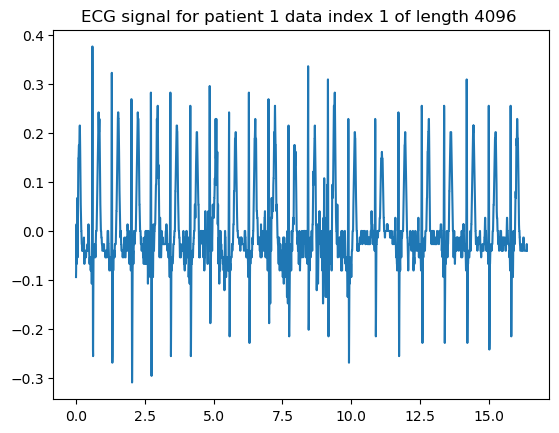

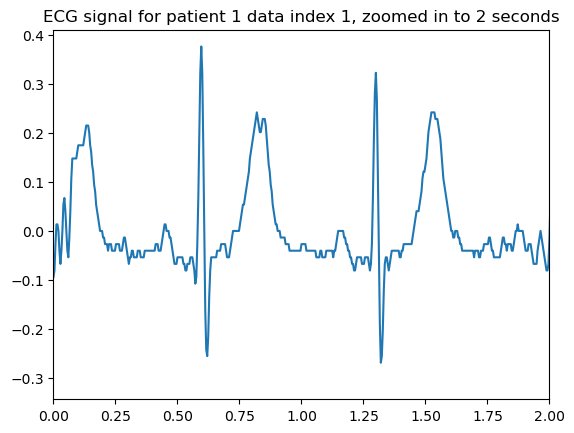

In [5]:
# lets select a portion of the signal and plot it in timedomain
data_idx = 1;
fsample = 250.0;
T_x = 1.0/fsample

# lets target a 64x64 spectogram. This is 64 time slices, and 64 frequency components
frame_size = 4096 # total number of samples for full spectogram
twindow = frame_size/fsample
print(f"twindow is {twindow} with frame size {frame_size} and fsample {fsample}")

# grab the selected part of the signal (first N points)
selected_signal =ecg_signal[data_idx][:frame_size];

# plot the selected signal in time domain
t_x = np.arange(frame_size) * T_x


# lets plot signal
plt.plot(t_x, selected_signal)
# print title with info on length
title = f"ECG signal for patient {patient_id} data index {data_idx} of length {len(selected_signal)} "
plt.title(title)
plt.show()

# and now zoomed in
plt.plot(t_x, selected_signal)
plt.xlim([0, 2])
title = f"ECG signal for patient {patient_id} data index {data_idx}, zoomed in to 2 seconds"
plt.title(title)
plt.show()


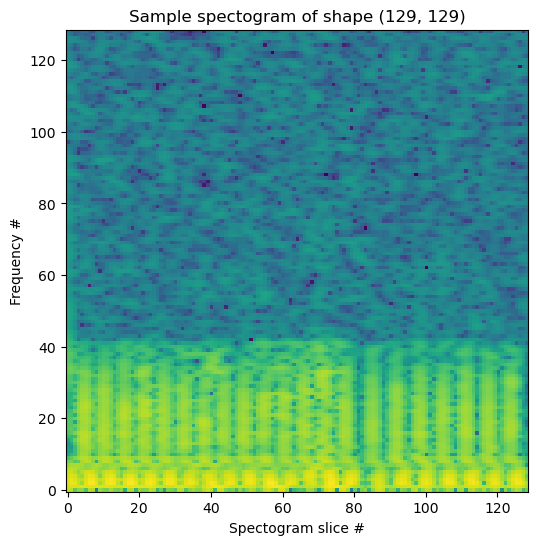

(129, 129)


In [6]:
import librosa
# for librosa.stft see: https://github.com/librosa/librosa/blob/14746316d931e331d1b6686d60bb593312b1d29e/librosa/core/spectrum.py#L55

window_size = 256
stride = 32
n_slices = frame_size//stride
n_freqs = 128

# compute short-time fourier transform (spectrogram)
x =librosa.stft(selected_signal, n_fft=window_size, hop_length=stride)
x = np.abs(x)
x = librosa.amplitude_to_db(x, ref = np.min)

# lets plot it
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(x, cmap='viridis')
ax.set_title(f"Sample spectogram of shape {x.shape}")
# add axis labels
ax.set_xlabel("Spectogram slice #")
ax.set_ylabel("Frequency #")
ax.invert_yaxis()
plt.show()
print(x.shape)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00099_batched.pkl.gz
(128, 128, 1)
tf.Tensor(0, shape=(), dtype=int32)


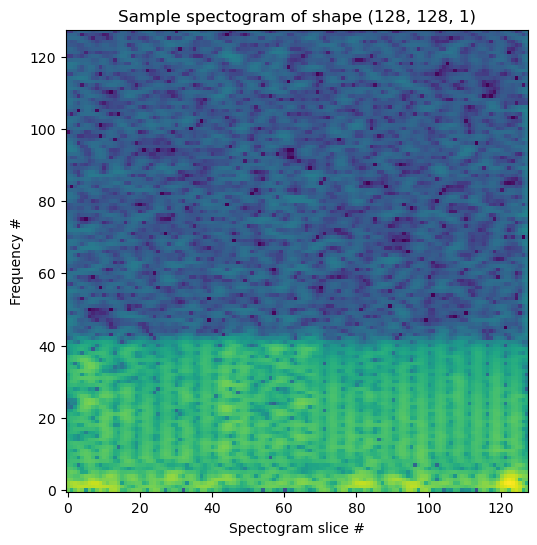

In [7]:
# lets test the generator
%load_ext autoreload
%autoreload 2
from transplant.datasets.icentia11k_spectogram import spectogram_beat_dataset

# generator parameters
window_size = 256
stride = 32
n_slices = frame_size//stride
n_freqs = 128
frame_size = 4096

# data parameters
db_dir = datadir + '/icentia11k_subset'
unzipped = False
patient_ids = np.array([0,1,88,89,96,97,98,99])

# initialize the dataset
train_data = spectogram_beat_dataset(db_dir, patient_ids, frame_size,
                   unzipped=unzipped, samples_per_patient=128, window_size = window_size, stride=stride, n_freqs=n_freqs)

# Take 1 sample from the dataset
sample_output = train_data.take(1)

# Iterate over the sample_dataset to get the first element
for x, y in sample_output:
    # x and y are EagerTensor
    print(x.shape)
    print(y)

    # lets plot it
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(x[:,:,0], cmap='viridis')
    ax.set_title(f"Sample spectogram of shape {x.shape}")
    # add axis labels
    ax.set_xlabel("Spectogram slice #")
    ax.set_ylabel("Frequency #")
    ax.invert_yaxis()
    plt.show()
    break

In [16]:

# lets define a 2d resnet
from transplant.modules.resnet2d import ResNet18_2D
import transplant.datasets.icentia11k as icentia11k
import tensorflow as tf

num_classes = len(icentia11k.ds_beat_names)
model = ResNet18_2D(num_classes=num_classes, include_top = False)
model = tf.keras.Sequential([
            model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_classes)
        ])
model.build(input_shape=(None, n_freqs, n_slices, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')])
# model.compile(optimizer="adam",
#                 loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net18_2d_3 (ResNet18_2  (None, 4, 16, 512)        11184640  
 D)                                                              
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 11187205 (42.68 MB)
Trainable params: 11177605 (42.64 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [17]:
# ok lets try some training...
db_dir = datadir + '/icentia11k_subset'
unzipped = False
patient_ids = np.array([0,1,88,89,96,97,98,99])
train_data = spectogram_beat_dataset(db_dir, patient_ids, frame_size,
                   unzipped=unzipped, samples_per_patient=128, window_size = window_size, stride=stride, n_freqs=n_freqs)

batch_size = 32
train_data = train_data.batch(batch_size)

model.fit(train_data,
            steps_per_epoch = 4, # 3 batches per epoch
            verbose=2,
            epochs=32)

Epoch 1/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00098_batched.pkl.gz
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00099_batched.pkl.gz
4/4 - 40s - loss: 1.5261 - acc: 0.5234 - 40s/epoch - 10s/step
Epoch 2/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00088_batched.pkl.gz
4/4 - 30s - loss: 1.2676 - acc: 0.6562 - 30s/epoch - 7s/step
Epoch 3/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00089_batched.pkl.gz
4/4 - 27s - loss: 1.8100 - acc: 0.6562 - 27s/epoch - 7s/step
Epoch 4/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00097_batched.pkl.gz
4/4 - 27s - loss: 1.2647 - acc: 0.6094 - 27s/epoch - 7s/step
Epoch 5/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00001_batched.pkl.gz
4/4 - 27s - loss: 0.5612 - acc: 0.8594 - 27s/epoch - 7s/step
Epoch 6/32
/home/myles/uiuc/DLH/ecg-transfer-learning/data/icentia11k_subset/00000_batched.pkl.gz
4/4 - 28s - loss: 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-04-20 09:46:51.997029: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838205440 exceeds 10% of free system memory.


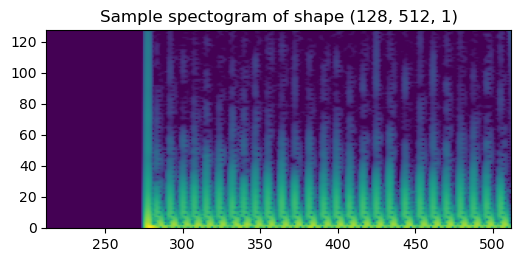

In [19]:
%load_ext autoreload
%autoreload 2
from finetuning.utils import train_test_split
from finetuning.spectrogram_datasets import create_spectogram_dataset_from_data

# inputs to data generators
val_size = 0.0625
batch_size = 32

# spectogram parameters
frame_size = 4096*4 # full size of input data
n_slices = frame_size//stride
n_freqs = 128

train_file = datadir + '/physionet_finetune/physionet_train.pkl'
test_file = datadir + '/physionet_finetune/physionet_test.pkl'

# load the data
train_data = load_pkl(train_file)
num_classes = train_data['y'].shape[1]

test_data = load_pkl(test_file)

# split into train and test
train_data, val_data = train_test_split(train_data, test_size=val_size, stratify=train_data['y'])

# create generators
train_data = create_spectogram_dataset_from_data(train_data, frame_size=frame_size, window_size = window_size, stride=stride, n_freqs=n_freqs).batch(batch_size)
val_data = create_spectogram_dataset_from_data(val_data, frame_size=frame_size, window_size = window_size, stride=stride, n_freqs=n_freqs).batch(batch_size) if val_data else None

test_data_single = create_spectogram_dataset_from_data(test_data, frame_size=frame_size, window_size = window_size, stride=stride, n_freqs=n_freqs)
test_data = create_spectogram_dataset_from_data(test_data, frame_size=frame_size, window_size = window_size, stride=stride, n_freqs=n_freqs).batch(batch_size) if test_data else None

sample_output = test_data_single.take(1)

# Iterate over the sample_dataset to get the first element
for x, y in sample_output:
    # x and y are EagerTensor

    # lets plot it
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(x[:,:,0], cmap='viridis')
    ax.set_title(f"Sample spectogram of shape {x.shape}")
    ax.invert_yaxis()

    # zoom into last 200 slices
    ax.set_xlim([n_slices-300, n_slices])

    plt.show()

    break

In [9]:
# define model for finetuning
finetuning_model = ResNet18_2D(num_classes=num_classes, include_top = False)
finetuning_model = tf.keras.Sequential([
        finetuning_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

# build the model
finetuning_model.build(input_shape=(None, n_freqs, n_slices, 1))
finetuning_model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])
finetuning_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net18_2d_1 (ResNet18_2  (None, 4, 16, 512)        11184640  
 D)                                                              
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 11186692 (42.67 MB)
Trainable params: 11177092 (42.64 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [10]:
finetuning_model.fit(train_data,
            steps_per_epoch = 4, # 3 batches per epoch
            verbose=2,
            epochs=32,
            validation_data=None,
            callbacks=[])

Epoch 1/32


2024-04-19 17:13:47.637429: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838205440 exceeds 10% of free system memory.


4/4 - 38s - loss: 2.2586 - acc: 0.3672 - 38s/epoch - 9s/step
Epoch 2/32
4/4 - 27s - loss: 1.2562 - acc: 0.5156 - 27s/epoch - 7s/step
Epoch 3/32
4/4 - 27s - loss: 1.3321 - acc: 0.5469 - 27s/epoch - 7s/step
Epoch 4/32
4/4 - 28s - loss: 1.0047 - acc: 0.4688 - 28s/epoch - 7s/step
Epoch 5/32
4/4 - 36s - loss: 0.9288 - acc: 0.6875 - 36s/epoch - 9s/step
Epoch 6/32
4/4 - 29s - loss: 0.9077 - acc: 0.6562 - 29s/epoch - 7s/step
Epoch 7/32
4/4 - 27s - loss: 1.0247 - acc: 0.6094 - 27s/epoch - 7s/step
Epoch 8/32
4/4 - 27s - loss: 0.9193 - acc: 0.5938 - 27s/epoch - 7s/step
Epoch 9/32
4/4 - 30s - loss: 0.9738 - acc: 0.6484 - 30s/epoch - 7s/step
Epoch 10/32
4/4 - 27s - loss: 0.9721 - acc: 0.6406 - 27s/epoch - 7s/step
Epoch 11/32
4/4 - 30s - loss: 0.9070 - acc: 0.6641 - 30s/epoch - 8s/step
Epoch 12/32
4/4 - 30s - loss: 1.1061 - acc: 0.5859 - 30s/epoch - 7s/step
Epoch 13/32
4/4 - 28s - loss: 0.8779 - acc: 0.6406 - 28s/epoch - 7s/step
Epoch 14/32
4/4 - 38s - loss: 0.9475 - acc: 0.5547 - 38s/epoch - 9s/ste